In [79]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from IPython.display import display, HTML
from typing import List
from mprompt.modules.emb_diff_module import EmbDiffModule
import numpy as np
import matplotlib
import imodelsx.util
from copy import deepcopy
import re
import notebook_helper
import mprompt.viz
import scipy.special
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from mprompt.methods.m4_evaluate import D5_Validator
import pandas as pd
from mprompt.modules.fmri_module import fMRIModule
from pprint import pprint
import joblib
import viz
from mprompt.config import RESULTS_DIR
import torch.cuda
import json
from sklearn.linear_model import RidgeCV
# EXPT_NAME in ['huth2016clusters_mar21_i_time_traveled', 'voxels_mar21_hands_arms_emergency']:
EXPT_NAME  = 'huth2016clusters_mar21_i_time_traveled'
EXPT_DIR = join(RESULTS_DIR, 'stories', EXPT_NAME)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
df = pd.read_csv(join(EXPT_DIR, 'timings.csv'))
df['word_len'] = df['word'].apply(len)
df['ends_in_period'] = df['word'].str.endswith('.')

# truncate values that are too large
df['timing'] = df['timing'].apply(lambda x: min(x, 0.85))

# fill na values with linreg
X = df[['word_len', 'ends_in_period']].values
y = df['timing'].values
idxs = ~pd.isna(y)
m = RidgeCV()
m.fit(X[idxs], y[idxs])
df['timing'][~idxs] = m.predict(X[~idxs])

# recompute running time
df['time_running'] = np.cumsum(df['timing'])
df.to_csv(join(EXPT_DIR, 'timings_processed.csv'), index=False)

/tmp/ipykernel_3195306/3771409005.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timing'][~idxs] = m.predict(X[~idxs])


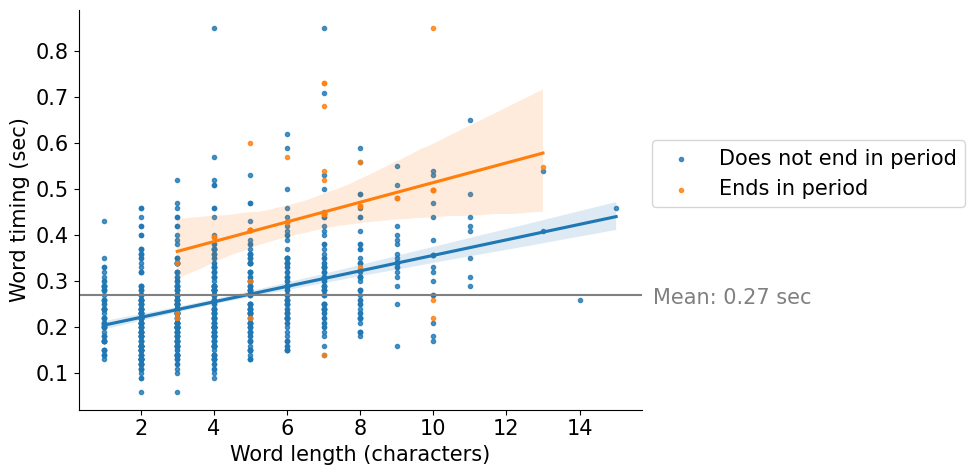

In [81]:
sns.lmplot(data=df, x='word_len', y='timing', hue='ends_in_period', markers='.', legend=False, aspect=2)
plt.xlabel('Word length (characters)')
plt.ylabel('Word timing (sec)')
plt.axhline(np.mean(df['timing']), color='gray')
plt.text(16, np.mean(df['timing']) - 0.02, f'Mean: {np.mean(df["timing"]):.2f} sec', color='gray')
# change legend label value
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles=handles, labels=['Does not end in period', 'Ends in period'], bbox_to_anchor=(1, 0.7))
plt.show()